In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

%matplotlib inline

In [10]:
# параметры распределений
mu0, sigma0 = -2., 1.
mu1, sigma1 = 3., 2.

In [11]:
def make_distr(mu, sigma):
    M = torch.FloatTensor([mu, mu])
    C = torch.FloatTensor([[sigma, 0],[0, sigma]])
    distr = torch.distributions.multivariate_normal.MultivariateNormal(M, C)
    return distr

In [12]:
d0 = make_distr(mu0, sigma0)
d1 = make_distr(mu1, sigma1)

In [13]:
d0.sample((5,))

tensor([[-1.0972, -3.2670],
        [-1.5461, -3.4862],
        [-3.1561, -3.3779],
        [-1.8970, -2.0314],
        [-2.4671, -3.9003]])

In [14]:
x_scale = np.linspace(-5, 5, 25)
y_scale = np.linspace(-5, 5, 25)
xx, yy = sp.meshgrid(x_scale, y_scale)
pos = np.dstack((xx, yy)).reshape(-1,2)

In [15]:
D0 = stats.multivariate_normal([mu0, mu0], sp.array([[sigma0, 0], [0, sigma0]]))
S0 = D0.pdf(pos)
D1 = stats.multivariate_normal([mu1, mu1], sp.array([[sigma1, 0], [0, sigma1]]))
S1 = D1.pdf(pos)

In [16]:
from mpl_toolkits.mplot3d import Axes3D

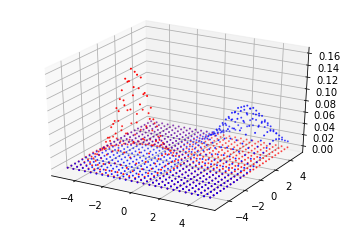

In [17]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(pos[:, 0], pos[:, 1], S0.reshape(-1, 1), color="r", s=1)
ax.scatter(pos[:, 0], pos[:, 1], S1.reshape(-1, 1), color="b", s=1)

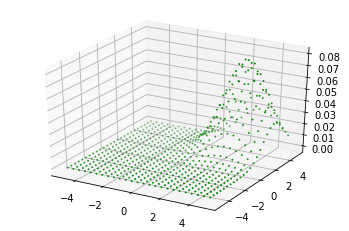

In [18]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
R = S1.reshape(-1, 1)/(S1.reshape(-1, 1)+S0.reshape(-1, 1))
ax.scatter(pos[:, 0], pos[:, 1], S1.reshape(-1, 1), color="g", s=1)

In [19]:
def sample(d0, d1, n=32):
    x0 = d0.sample((n,))
    x1 = d1.sample((n,))
    y0 = torch.zeros((n, 1))
    y1 = torch.ones((n, 1))
    return torch.cat([x0, x1], 0), torch.cat([y0, y1], 0)

In [20]:
layer = nn.Linear(1, 1)
print([p.data[0] for p in layer.parameters()])
layer_opt = optim.SGD(lr=1e-3, params=list(layer.parameters()))

[tensor([-0.5964]), tensor(-0.8482)]


In [58]:
net = nn.Sequential(nn.Linear(2, 10), nn.ReLU(), nn.Linear(10, 5), nn.Sigmoid(), nn.Linear(5, 1))
for p in net.parameters():
    print(p.data)
net_opt = optim.SGD(lr=1e-2, params=list(net.parameters()))

tensor([[ 0.2634, -0.3177],
        [-0.2109, -0.3390],
        [-0.6558,  0.4517],
        [-0.5847,  0.6725],
        [ 0.5404, -0.0467],
        [ 0.2143, -0.1189],
        [-0.3576,  0.3271],
        [ 0.2881,  0.6640],
        [ 0.0774,  0.2295],
        [-0.5330,  0.3400]])
tensor([-0.7067,  0.5879, -0.0733,  0.4419, -0.5820, -0.5108,  0.3202, -0.4791,
         0.5349, -0.5972])
tensor([[ 0.2246,  0.0037, -0.0916,  0.2390,  0.1355, -0.1695,  0.0663,  0.0037,
          0.0290,  0.2148],
        [ 0.1444,  0.0073, -0.1844,  0.1418, -0.1742,  0.1135, -0.2087, -0.1003,
          0.3125,  0.1616],
        [-0.1408, -0.0884, -0.0168,  0.2123, -0.2719, -0.2927,  0.2489,  0.1807,
          0.0575,  0.1168],
        [ 0.0785, -0.0711,  0.1928,  0.2316,  0.3099,  0.0114,  0.1385,  0.0291,
          0.1929,  0.1974],
        [ 0.2064,  0.0578,  0.0669, -0.3124, -0.2159,  0.1094,  0.1247, -0.2840,
          0.2765, -0.1384]])
tensor([-0.0050, -0.0716, -0.0495, -0.1777, -0.1413])
tensor([[ 0.

In [59]:
log_freq = 500
for i in range(20000*3):
    if i%log_freq == 0:
        with torch.no_grad():
            x, y = sample(d0, d1, 100000)
            out = F.sigmoid(net(x))
            loss = F.binary_cross_entropy(out, y)
        print('Ошибка после %d итераций: %f' %(i/log_freq, loss))
    net_opt.zero_grad()
    x, y = sample(d0, d1, 1024)
    out = net(x)
    loss = F.binary_cross_entropy_with_logits(out, y)
    loss.backward()
    net_opt.step()

/home/user/DL/VENV/pytorch/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Ошибка после 0 итераций: 0.772032
Ошибка после 1 итераций: 0.551339
Ошибка после 2 итераций: 0.275586
Ошибка после 3 итераций: 0.144394
Ошибка после 4 итераций: 0.092121
Ошибка после 5 итераций: 0.066831
Ошибка после 6 итераций: 0.051949
Ошибка после 7 итераций: 0.042822
Ошибка после 8 итераций: 0.036205
Ошибка после 9 итераций: 0.031753
Ошибка после 10 итераций: 0.028167
Ошибка после 11 итераций: 0.025177
Ошибка после 12 итераций: 0.022992
Ошибка после 13 итераций: 0.021523
Ошибка после 14 итераций: 0.019746
Ошибка после 15 итераций: 0.018574
Ошибка после 16 итераций: 0.017375
Ошибка после 17 итераций: 0.016749
Ошибка после 18 итераций: 0.016012
Ошибка после 19 итераций: 0.015073
Ошибка после 20 итераций: 0.014749
Ошибка после 21 итераций: 0.014332
Ошибка после 22 итераций: 0.013335
Ошибка после 23 итераций: 0.012970
Ошибка после 24 итераций: 0.012839
Ошибка после 25 итераций: 0.012416
Ошибка после 26 итераций: 0.011964
Ошибка после 27 итераций: 0.011550
Ошибка после 28 итераций: 0.01

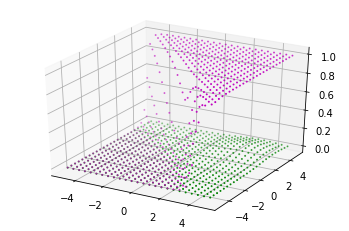

In [61]:
pos_tensor = torch.tensor(pos, dtype=torch.float)
with torch.no_grad():
    dist = F.sigmoid(net(pos_tensor)).numpy()
    fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
R = S1.reshape(-1, 1)/(S1.reshape(-1, 1)+S0.reshape(-1, 1))
ax.scatter(pos[:, 0], pos[:, 1], S1.reshape(-1, 1), color="g", s=1)
ax.scatter(pos[:, 0], pos[:, 1], dist.reshape(-1, 1), color="m", s=1)